<h1>Setup and Imports</h1>
Installing Hugging Face's nlp package
Importing libraries

In [45]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


<h3>Defining the necessary functions</h3>

In [46]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

In [47]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [48]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [49]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [50]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [51]:
tweets, labels = get_tweets(train)


In [52]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

In [53]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[3]]))

[[2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497]]


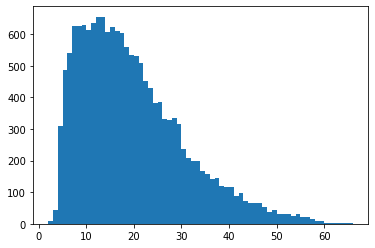

In [54]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [55]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [56]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [57]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [58]:
classes = set(labels)
print(classes)

{'sadness', 'anger', 'love', 'fear', 'surprise', 'joy'}


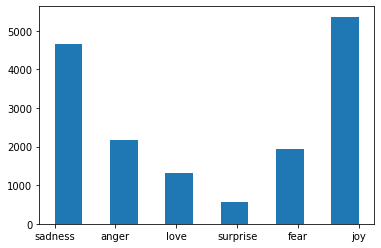

In [59]:
plt.hist(labels, bins=11)
plt.show()

In [60]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [61]:
classes_to_index


{'sadness': 0, 'anger': 1, 'love': 2, 'fear': 3, 'surprise': 4, 'joy': 5}

In [62]:
index_to_classes

{0: 'sadness', 1: 'anger', 2: 'love', 3: 'fear', 4: 'surprise', 5: 'joy'}

In [63]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [64]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


In [65]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [66]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [67]:
val_tweets[0], val_labels[0]


('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [68]:
history = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/50
500/500 [==============================] - 14s 20ms/step - loss: 1.3615 - accuracy: 0.4336 - val_loss: 1.0116 - val_accuracy: 0.6195
Epoch 2/50
500/500 [==============================] - 9s 18ms/step - loss: 0.7193 - accuracy: 0.7125 - val_loss: 0.6260 - val_accuracy: 0.7520
Epoch 3/50
500/500 [==============================] - 9s 18ms/step - loss: 0.3954 - accuracy: 0.8592 - val_loss: 0.4656 - val_accuracy: 0.8525
Epoch 4/50
500/500 [==============================] - 9s 18ms/step - loss: 0.2622 - accuracy: 0.9157 - val_loss: 0.4315 - val_accuracy: 0.8645
Epoch 5/50
500/500 [==============================] - 10s 19ms/step - loss: 0.1788 - accuracy: 0.9408 - val_loss: 0.3693 - val_accuracy: 0.8895
Epoch 6/50
500/500 [==============================] - 10s 20ms/step - loss: 0.1330 - accuracy: 0.9563 - val_loss: 0.3784 - val_accuracy: 0.8910
Epoch 7/50
500/500 [==============================] - 10s 20ms/step - loss: 0.1045 - accuracy: 0.9674 - val_loss: 0.4497 - val_accuracy: 0.

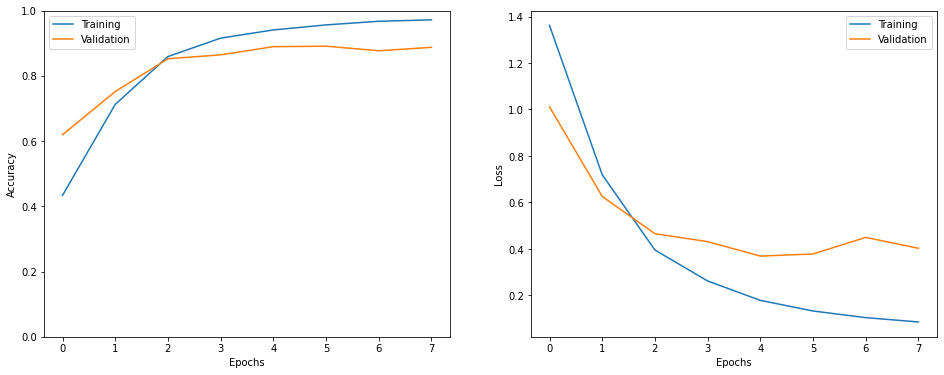

In [69]:
show_history(history)

In [70]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [71]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4272 - accuracy: 0.8855


In [92]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(p).astype('int')]
print('Predicted Emotion:', pred_class)

Sentence: i was feeling the need for some christmas crafting this week especially after seeing a couple of lovely quilty christmas projects at stitch group
Emotion: love
Predicted Emotion: love


In [102]:
y_predict = np.argmax(model.predict(test_sequences), axis=1)


In [103]:
len(y_predict)

2000

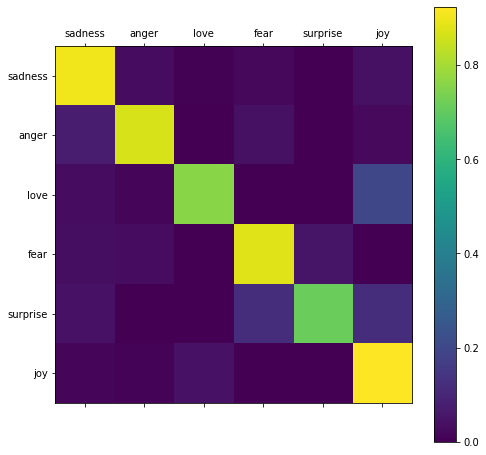

In [104]:
show_confusion_matrix(test_labels, y_predict, list(classes))